In [1]:
# 訓練期間とテスト期間を日付で指定
train_start_date    = '2018-04-01 00:00:00'
train_end_date      = '2018-06-30 23:59:59'
test_start_date     = '2018-07-01 00:00:00'
test_end_date       = '2018-07-11 23:59:59'

# train_start_date    = '2018-07-07 00:00:00'
# train_end_date      = '2018-07-09 02:59:59'
# test_start_date     = '2018-07-09 01:00:00'
# test_end_date       = '2018-07-09 07:59:59'

train_days          = 180

# mesh
PATH_mesh = '../csv_data/meshID/ID_Kurashiki_Mabicho_shelter.csv'

# figサイズのテンプレート
template1=(15,6)

#Exogenous info, True or False
# exDataIsAll=True  
exDataIsAll=False


best_param_arima =[2, 1, 6]
best_param_seasonal= [1, 1, 3, 24]

# Import variables

In [2]:
# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

import matplotlib.dates as dates
import datetime as dt
from datetime import datetime
import matplotlib.dates as mdates
import math
import itertools
import pandas.tseries.offsets as offsets
import jpholiday  
  #日本の祝日を取得するライブラリ

import warnings
warnings.simplefilter('ignore')
import psycopg2

## Date

In [3]:
### 日付加工：外部変数を読みたるため
split_date = test_start_date

tmp_st = datetime.strptime(test_start_date, '%Y-%m-%d %H:%M:%S')
tmp_en = datetime.strptime(test_end_date, '%Y-%m-%d %H:%M:%S')
tmp_diff = tmp_en - tmp_st
forecasting_hours= int(tmp_diff.total_seconds() / 3600)

date_st = train_start_date[0:4]+train_start_date[5:7]+train_start_date[8:10]+train_start_date[11:13]+train_start_date[14:16]
date_en = test_end_date[0:4]+test_end_date[5:7]+test_end_date[8:10]+test_end_date[11:13]+test_end_date[14:16]

print(train_start_date,'\t→\t',test_end_date)
print(date_st,'\t\t→\t',date_en)


2018-04-01 00:00:00 	→	 2018-07-11 23:59:59
201804010000 		→	 201807112359


## Mesh ID

In [4]:
import pandas as pd
df = pd.read_csv(PATH_mesh)
print(df.head())

# KEY_CODEを追加していく
areas = []
for area in df['KEY_CODE']:
    # print(area)
    areas.append(area)

print()
# print(f'{len(areas)} areas in total：{areas}')

# SQLで送信するようにデータを加工
areas_str=''
for k in areas:
    areas_str+=(str(k)+',')
areas_str=areas_str[:-1]  #最後の一文字に余分なカンマが入っているのでその部分を除いて変数を更新
areas_list = areas_str.split(',')

print(f'{len(areas_list)} areas in total: {areas_list}')


    KEY_CODE  MESH1_ID  MESH2_ID  MESH3_ID  MESH4_ID  OBJ_ID
0  513375262      5133        75        26         2   24106
1  513375264      5133        75        26         4   24108
2  513375653      5133        75        65         3   24263
3  513375753      5133        75        75         3   24303
4  513375761      5133        75        76         1   24305

6 areas in total: ['513375262', '513375264', '513375653', '513375753', '513375761', '513375763']


## Import Population data

In [5]:
import pandas as pd
import psycopg2
import datetime
import matplotlib.pyplot as plt

#　print用の名前をつけているだけ
name_trainPeriod='    Train(\t'+train_start_date[0:10]+'\t→\t'+train_end_date[0:10]+')'
print(name_trainPeriod)
name_testPeriod='    Test(\t'+test_start_date[0:10]+'\t→\t'+test_end_date[0:10]+')'
print(name_testPeriod)



# データベースの接続情報
connection_config = {
    'user': 'shin',
    'password': 'shin_password',
    'port': '5432',
    'database': 'mobaku_base',
    'host': '10.33.230.198'
}
connection = psycopg2.connect(**connection_config)

with connection.cursor() as cursor:
    cursor.execute("SET pg_strom.enabled=off;")
    connection.commit()


# データを取得（datetimeごとのpopulation合計を計算）
sql_query = f"""
SELECT datetime, SUM(population) AS total_population
FROM population_00000
WHERE mesh_id IN ({','.join(areas_list)})
AND datetime BETWEEN '{train_start_date}' AND '{test_end_date}'
GROUP BY datetime
ORDER BY datetime;
"""


df_pop = pd.read_sql(sql=sql_query, con=connection)
df_pop = df_pop.drop(0) #外生変数との数を調整するため．
pop_hours=df_pop['total_population']

    Train(	2018-04-01	→	2018-06-30)
    Test(	2018-07-01	→	2018-07-11)


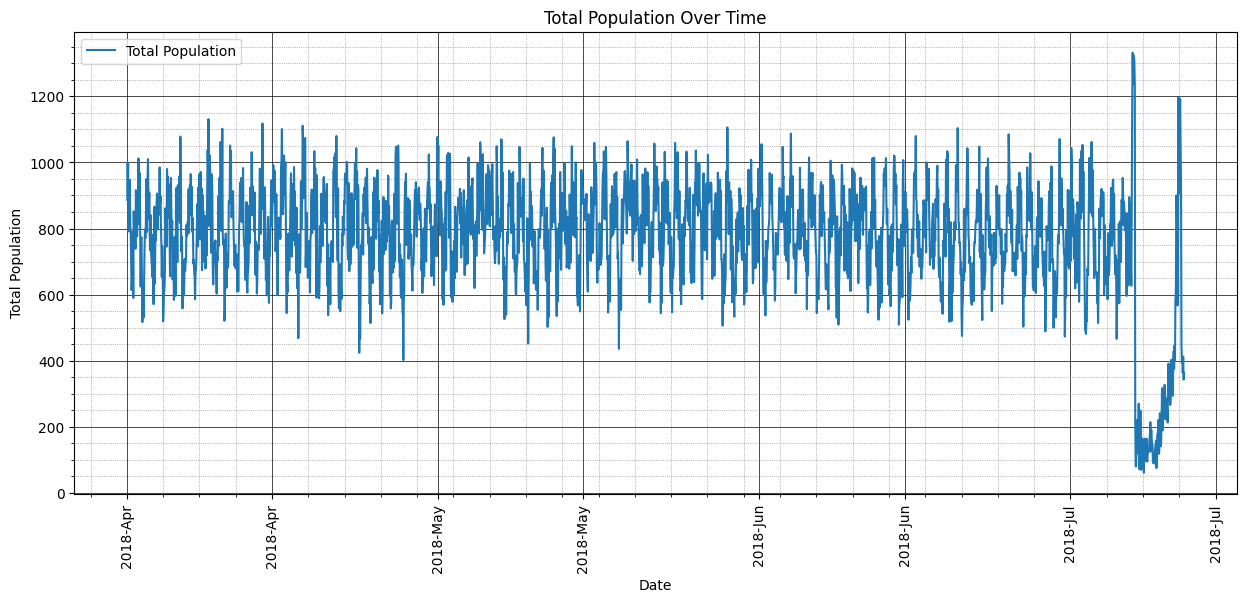

In [6]:
import matplotlib.dates as mdates

df_pop=df_pop.set_index(df_pop['datetime'])
# df_pop['total_population'].plot()


# グラフの描画
plt.figure(figsize=template1)
plt.plot(df_pop['datetime'],df_pop['total_population'],label='Total Population')
plt.xlabel('Date')
plt.ylabel('Total Population')
plt.title('Total Population Over Time')
plt.legend()

# 主グリッドの設定
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
# 補助グリッドの設定
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

# 横軸の表記を「英字＋90度回転」 にする
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%b"))

# グラフを表示
plt.show()

In [7]:
# datetime列をdatetime型に変換
df_pop['datetime'] = pd.to_datetime(df_pop['datetime'])

# データフレームの表示
df_pop

,datetime,total_population
datetime,,
2018-04-01 01:00:00,2018-04-01 01:00:00,998
2018-04-01 02:00:00,2018-04-01 02:00:00,884
2018-04-01 03:00:00,2018-04-01 03:00:00,997
2018-04-01 04:00:00,2018-04-01 04:00:00,791
2018-04-01 05:00:00,2018-04-01 05:00:00,833
...,...,...
2018-07-11 19:00:00,2018-07-11 19:00:00,412
2018-07-11 20:00:00,2018-07-11 20:00:00,363
2018-07-11 21:00:00,2018-07-11 21:00:00,412


## Import exogenous data 

In [8]:
import matplotlib.pyplot as plt
import csv
import datetime

PATH = r'../csv_data/amedas_data/kurashiki/output/combined_output.csv'

In [9]:
import datetime

timeLine=[]

y_precipitation=[]
num_precipitation=4

y_temperature=[]
num_temperature=6

y_windspeed=[]
num_windspeed=8

print(f'date_st: {date_st}')
print(f'date_en: {date_en}')


with open(PATH,'r',encoding='cp932') as csvfile:
    hours =csv.reader(csvfile,delimiter=',')
    for hour in hours:
        # ヘッダー部分をカットする
        if int(hour[0])>2:
            # print(hour)

            # hour[1]~hour[4]を用いてhour_keyを作成するパート-----------------------------------
            # hour[1]などはもともとstrだから,intに直す(→するとstrに戻すときに2桁表示が可能になる)
            val_year=int(hour[0])
            val_month=int(hour[1])
            val_day=int(hour[2])
            val_hour=int(hour[3])
            # 合体させる
            hour_str = f"{val_year:04}" + f"{val_month:02}" + f"{val_day:02}" + f"{val_hour:02}" + "00"
            #print(hour_str)

            # データを抽出してリストを作るパート------------------------------------------
            if date_st <= hour_str and hour_str <= date_en:
                # days
                val_year=int(hour[0])
                val_month=int(hour[1])
                val_day=int(hour[2])
                val_hour=int(hour[3])
                # print(val_year,val_month,val_day,val_hour)

                if val_hour ==24:
                    val_hour=0
                    hour_key = datetime.datetime(val_year,val_month,val_day,val_hour) + datetime.timedelta(days=1)
                else:
                    hour_key = datetime.datetime(val_year,val_month,val_day,val_hour)


                # X axis
                timeLine.append(hour_key)

                # Precipitation
                y_precipitation.append(float(hour[num_precipitation]))

                # Temperature
                y_temperature.append(float(hour[num_temperature]))

                # WindSpeed
                y_windspeed.append(float(hour[num_windspeed]))


date_st: 201804010000
date_en: 201807112359


In [10]:
# pop_hours_max = max(pop_hours)
# pop_hours_min = min(pop_hours)

y_precipitation_max = max(y_precipitation)
y_precipitation_min = min(y_precipitation)

y_windspeed_max = max(y_windspeed)
y_windspeed_min = min(y_windspeed)

y_temperature_max = max(y_temperature)
y_temperature_min = min(y_temperature)

# pop_hours_standard       = [((n-pop_hours_min)/(pop_hours_max-pop_hours_min)) for n in pop_hours]
y_precipitation_standard = [((n-y_precipitation_min)/(y_precipitation_max-y_precipitation_min)) for n in y_precipitation]
y_windspeed_standard     = [((n-y_windspeed_min)/(y_windspeed_max-y_windspeed_min)) for n in y_windspeed]
y_temperature_standard   = [((n-y_temperature_min)/(y_temperature_max-y_temperature_min)) for n in y_temperature]


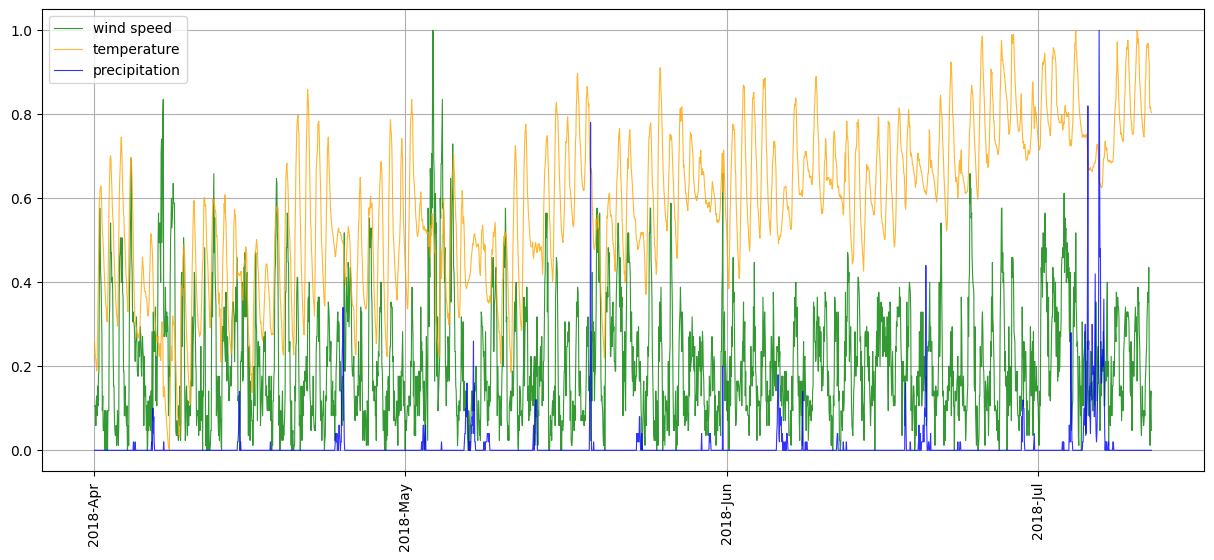

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=template1)  # Figureのサイズを指定

# 最後xx日間の日付のみ表示 (コメントアウト)
# xx = 12
# ax.plot_date(timeLine[xx*(-24):], y_precipitation_standard[xx*(-24):], '-', label='precipitation', linewidth=0.8)
# ax.plot_date(timeLine[xx*(-24):], y_windspeed_standard[xx*(-24):], '-', label='wind speed', linewidth=0.8)
# ax.plot_date(timeLine[xx*(-24):], y_temperature_standard[xx*(-24):], '-', label='temperature', linewidth=0.8)

# 日付を全体表示
ax.plot_date(timeLine[:], y_windspeed_standard[:], '-', label='wind speed', color='green',linewidth=0.8,alpha=0.8)
ax.plot_date(timeLine[:], y_temperature_standard[:], '-', label='temperature', color='orange',linewidth=0.8,alpha=0.8)
ax.plot_date(timeLine[:], y_precipitation_standard[:], '-', label='precipitation', color='blue', linewidth=0.8,alpha=0.8)

ax.legend()
ax.grid()

# 月単位での表示を設定
locator = mdates.MonthLocator()  # 月単位で表示
ax.xaxis.set_major_locator(locator)

# フォーマットを月単位に設定
formatter = mdates.DateFormatter('%Y-%b')  # 年-月形式で表示
ax.xaxis.set_major_formatter(formatter)


# x軸のラベルを縦向きに回転
ax.tick_params(axis='x', rotation=90)

plt.show()

In [12]:
# 時系列をdatetime形式に変換
timeLine = pd.to_datetime(timeLine)

# 新しいDataFrameを作成
df_ex = pd.DataFrame({
    'time': timeLine,
    'population': pop_hours,
    'precipitation': y_precipitation,
    'temperature': y_temperature,
    'windspeed': y_windspeed
})

# 時系列をインデックスに設定
df_ex = df_ex.set_index('time')


print(df_ex)


                     population  precipitation  temperature  windspeed
time                                                                  
2018-04-01 01:00:00         998            0.0         10.3        0.9
2018-04-01 02:00:00         884            0.0          9.7        0.9
2018-04-01 03:00:00         997            0.0          9.2        0.9
2018-04-01 04:00:00         791            0.0          9.1        0.5
2018-04-01 05:00:00         833            0.0          8.7        1.0
...                         ...            ...          ...        ...
2018-07-11 19:00:00         412            0.0         26.8        1.1
2018-07-11 20:00:00         363            0.0         26.5        0.1
2018-07-11 21:00:00         412            0.0         26.6        1.0
2018-07-11 22:00:00         343            0.0         26.3        1.2
2018-07-11 23:00:00         363            0.0         26.2        0.4

[2447 rows x 4 columns]


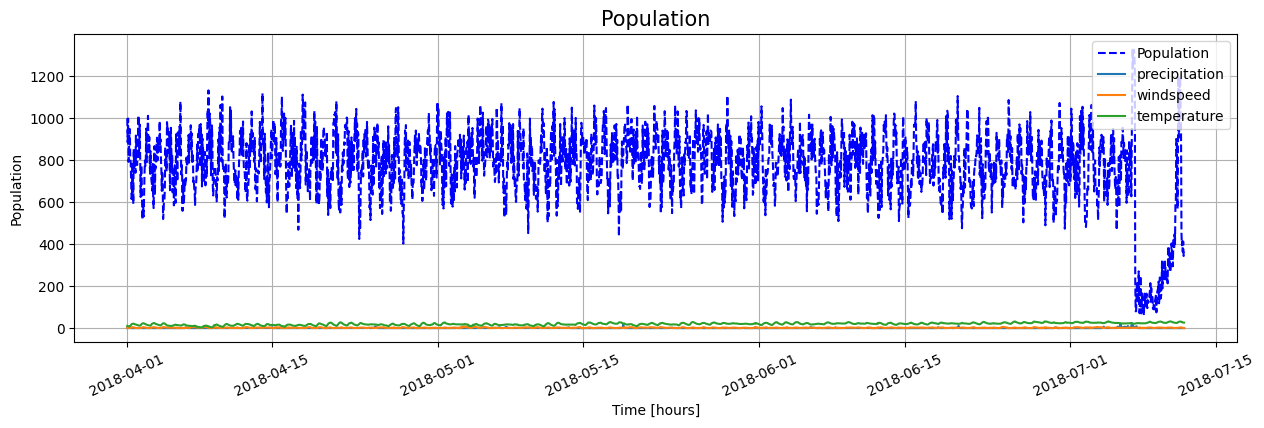

In [13]:
plt.rcParams["figure.figsize"] = [15,4.0]  

plt.plot(timeLine, pop_hours, color = 'b', linestyle = 'dashed',label = "Population") 
plt.plot(timeLine,y_precipitation,label='precipitation')
plt.plot(timeLine,y_windspeed,label='windspeed')
plt.plot(timeLine,y_temperature,label='temperature')


plt.xticks(rotation = 25) 
plt.xlabel('Time [hours]') 
plt.ylabel('Population') 
plt.title('Population', fontsize = 15) 
plt.grid()
plt.legend()
plt.show()


わかること
- 7/6夜，倉敷市益城町の高梁川の水位が上昇，氾濫した．
- それまでは夜間が最も人口が多かったが，そのときは夜間に人口減少がみられる．
- 7/7 13:20でも5mの氾濫水位があった
- 

- 停電？
- 3month train?
- sarimax or LSTM
- 1h ahead prediction
- 

check variables

In [14]:
print(f'timeline: {len(timeLine)}')
print(f'pop_hours: {len(pop_hours)}')
print(f'precipitation: {len(y_precipitation)}')
print(f'wind: {len(y_windspeed)}')
print(f'temperature: {len(y_temperature)}')



timeline: 2447
pop_hours: 2447
precipitation: 2447
wind: 2447
temperature: 2447


In [15]:
a = timeLine.tolist()

timeLine=[]
for k in a:
    timeLine.append(k.to_pydatetime())
print(timeLine)

[datetime.datetime(2018, 4, 1, 1, 0), datetime.datetime(2018, 4, 1, 2, 0), datetime.datetime(2018, 4, 1, 3, 0), datetime.datetime(2018, 4, 1, 4, 0), datetime.datetime(2018, 4, 1, 5, 0), datetime.datetime(2018, 4, 1, 6, 0), datetime.datetime(2018, 4, 1, 7, 0), datetime.datetime(2018, 4, 1, 8, 0), datetime.datetime(2018, 4, 1, 9, 0), datetime.datetime(2018, 4, 1, 10, 0), datetime.datetime(2018, 4, 1, 11, 0), datetime.datetime(2018, 4, 1, 12, 0), datetime.datetime(2018, 4, 1, 13, 0), datetime.datetime(2018, 4, 1, 14, 0), datetime.datetime(2018, 4, 1, 15, 0), datetime.datetime(2018, 4, 1, 16, 0), datetime.datetime(2018, 4, 1, 17, 0), datetime.datetime(2018, 4, 1, 18, 0), datetime.datetime(2018, 4, 1, 19, 0), datetime.datetime(2018, 4, 1, 20, 0), datetime.datetime(2018, 4, 1, 21, 0), datetime.datetime(2018, 4, 1, 22, 0), datetime.datetime(2018, 4, 1, 23, 0), datetime.datetime(2018, 4, 2, 0, 0), datetime.datetime(2018, 4, 2, 1, 0), datetime.datetime(2018, 4, 2, 2, 0), datetime.datetime(2018,

list から pandas.Series に変更

In [16]:
timeLine_series         =pd.Series(timeLine,name='timeLine')
pop_hours_series        =pd.Series(pop_hours,name='pop_hours')
y_precipitation_series  =pd.Series(y_precipitation,name='y_precipitation')
y_temperature_series    =pd.Series(y_temperature,name='y_temperature')
y_windspeed_series      =pd.Series(y_windspeed,name='y_windspeed')

# なぜか以下の変数のみindexがずれて設定されていたため，0スタートに直す．
pop_hours_series.index = range(0, len(pop_hours_series))

In [17]:
print(len(timeLine_series))
print(len(pop_hours_series))
print(len(y_precipitation_series))

2447
2447
2447


In [18]:
# [timeline, pop, precipitation]のSeriesの結合
all_concated = pd.concat([timeLine_series,pop_hours_series,y_precipitation_series,y_windspeed_series,y_temperature_series],axis=1)

# timeLine index 
all_concated = all_concated.set_index('timeLine',drop=True)


print(all_concated)

                     pop_hours  y_precipitation  y_windspeed  y_temperature
timeLine                                                                   
2018-04-01 01:00:00        998              0.0          0.9           10.3
2018-04-01 02:00:00        884              0.0          0.9            9.7
2018-04-01 03:00:00        997              0.0          0.9            9.2
2018-04-01 04:00:00        791              0.0          0.5            9.1
2018-04-01 05:00:00        833              0.0          1.0            8.7
...                        ...              ...          ...            ...
2018-07-11 19:00:00        412              0.0          1.1           26.8
2018-07-11 20:00:00        363              0.0          0.1           26.5
2018-07-11 21:00:00        412              0.0          1.0           26.6
2018-07-11 22:00:00        343              0.0          1.2           26.3
2018-07-11 23:00:00        363              0.0          0.4           26.2

[2447 rows 

In [19]:
from datetime import datetime, timedelta

# 分割日時 mdayの設定 (最終日から{forecasting_hours}時間前)
mday = split_date
# 最終日から{forecasting_hours}時間前の日時を計算し、mdayに設定します。
print(f'最終日から{forecasting_hours}時間前の日時 :{mday}')
print(f'最終日                : {test_end_date}')

# 訓練用indexと検証用indexを作る
train_index = all_concated.index <= mday
    #2020-01-16 - 2022-11-16
    #Series of 'False' and 'True'
test_index  = all_concated.index > mday
    #2022-11-16 - 2022-11-30
    #Series of 'False' and 'True'

print(train_index)
print()
print(test_index)

最終日から263時間前の日時 :2018-07-01 00:00:00
最終日                : 2018-07-11 23:59:59
[ True  True  True ... False False False]

[False False False ...  True  True  True]


In [20]:
# 入力データの分割
x_train = all_concated[train_index]
x_test  = all_concated[test_index]

ts         = x_train['pop_hours']
exo_train = x_train.drop(columns='pop_hours')

exo_test = x_test.drop(columns='pop_hours')

In [21]:
print(x_train)
print()
print(x_test)

                     pop_hours  y_precipitation  y_windspeed  y_temperature
timeLine                                                                   
2018-04-01 01:00:00        998              0.0          0.9           10.3
2018-04-01 02:00:00        884              0.0          0.9            9.7
2018-04-01 03:00:00        997              0.0          0.9            9.2
2018-04-01 04:00:00        791              0.0          0.5            9.1
2018-04-01 05:00:00        833              0.0          1.0            8.7
...                        ...              ...          ...            ...
2018-06-30 20:00:00        684              0.0          1.2           26.2
2018-06-30 21:00:00        679              0.0          1.7           25.9
2018-06-30 22:00:00        914              0.0          1.2           25.3
2018-06-30 23:00:00        884              0.0          1.3           25.0
2018-07-01 00:00:00        700              0.0          1.0           24.6

[2184 rows 

# データの可視化

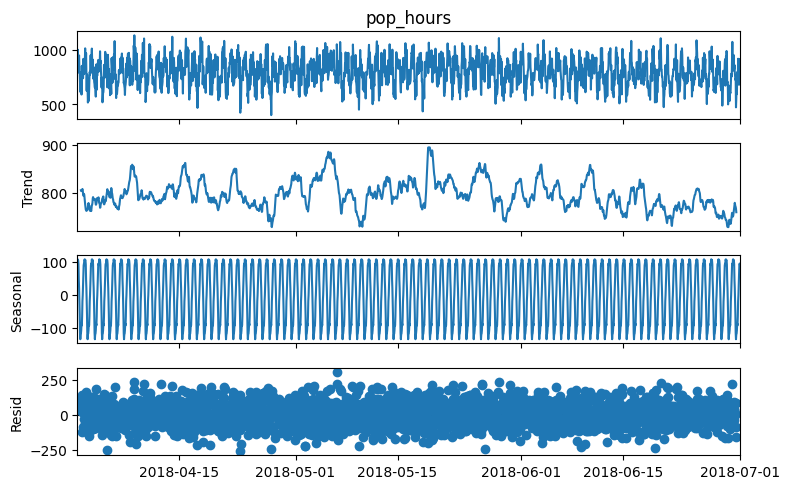

In [22]:
import statsmodels.api as sm

# 周期性の確認
res = sm.tsa.seasonal_decompose(ts, period=24)
    #ts is numbers of COVID in Tokyo in tyepe of Series with Index of 'Date'
fig = res.plot()
fig.set_size_inches(8,5)
fig.tight_layout()

<Axes: xlabel='timeLine'>

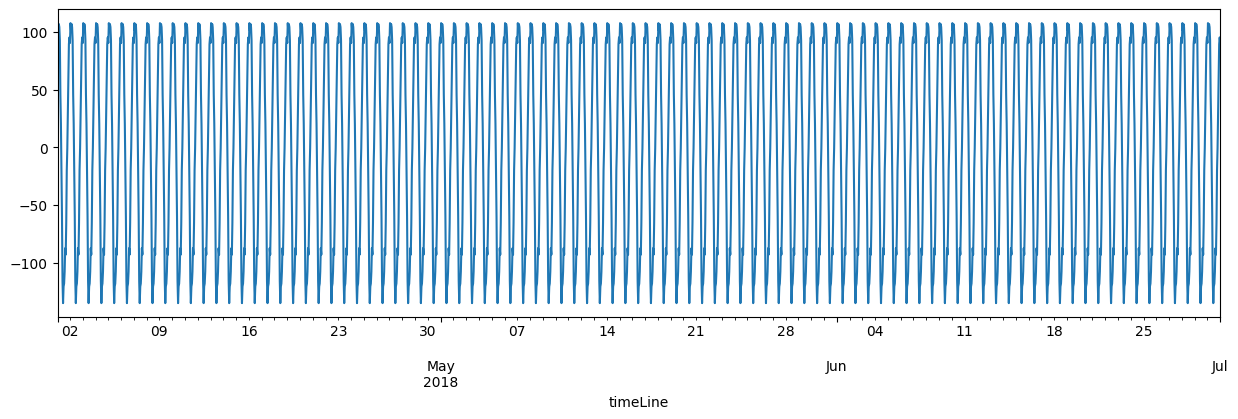

In [23]:
#seasonal データの取り出し
res.seasonal.plot()

## ディッキーフラー検定

ADF Statistic: -5.558052
p-value: 0.000002
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


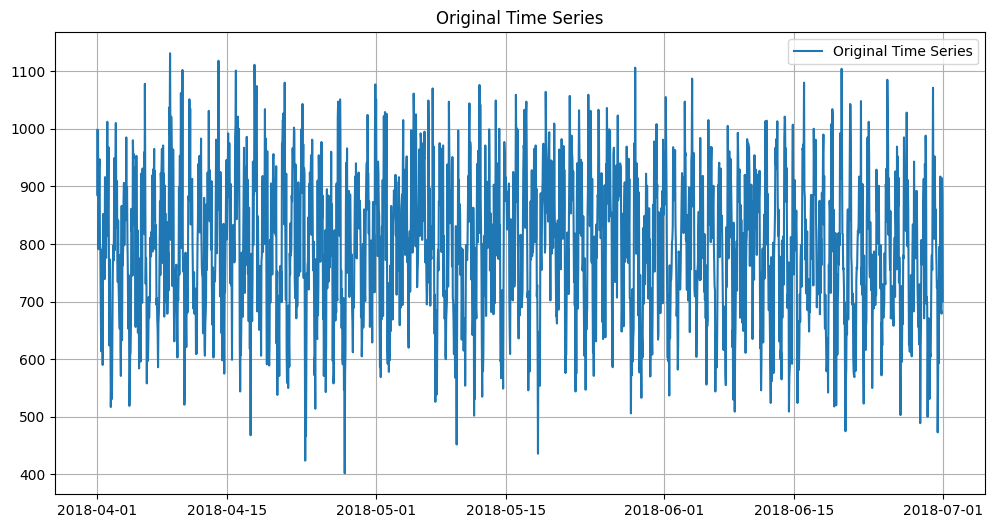

p-value < 0.05, 時系列は定常です。


In [24]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# ディッキーフラー検定を実行
result = adfuller(ts)

# 結果の出力
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# グラフの描画
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Original Time Series')
plt.title('Original Time Series')
plt.legend()
plt.grid()
plt.show()

# p値を確認し、時系列が定常かどうかを判断
if result[1] < 0.05:
    print("p-value < 0.05, 時系列は定常です。")
else:
    print("p-value >= 0.05, 時系列は非定常です。")

    # 非定常なら階差を取る
    ts_diff = ts.diff().dropna()

    # 階差のグラフ
    plt.figure(figsize=(12, 6))
    plt.plot(ts_diff, label='Differenced Time Series', color='orange')
    plt.title('Differenced Time Series')
    plt.legend()
    plt.grid()
    plt.show()

    # 階差後のディッキーフラー検定を再度実行
    result_diff = adfuller(ts_diff)
    print('After differencing:')
    print('ADF Statistic: %f' % result_diff[0])
    print('p-value: %f' % result_diff[1])
    print('Critical Values:')
    for key, value in result_diff[4].items():
        print('\t%s: %.3f' % (key, value))

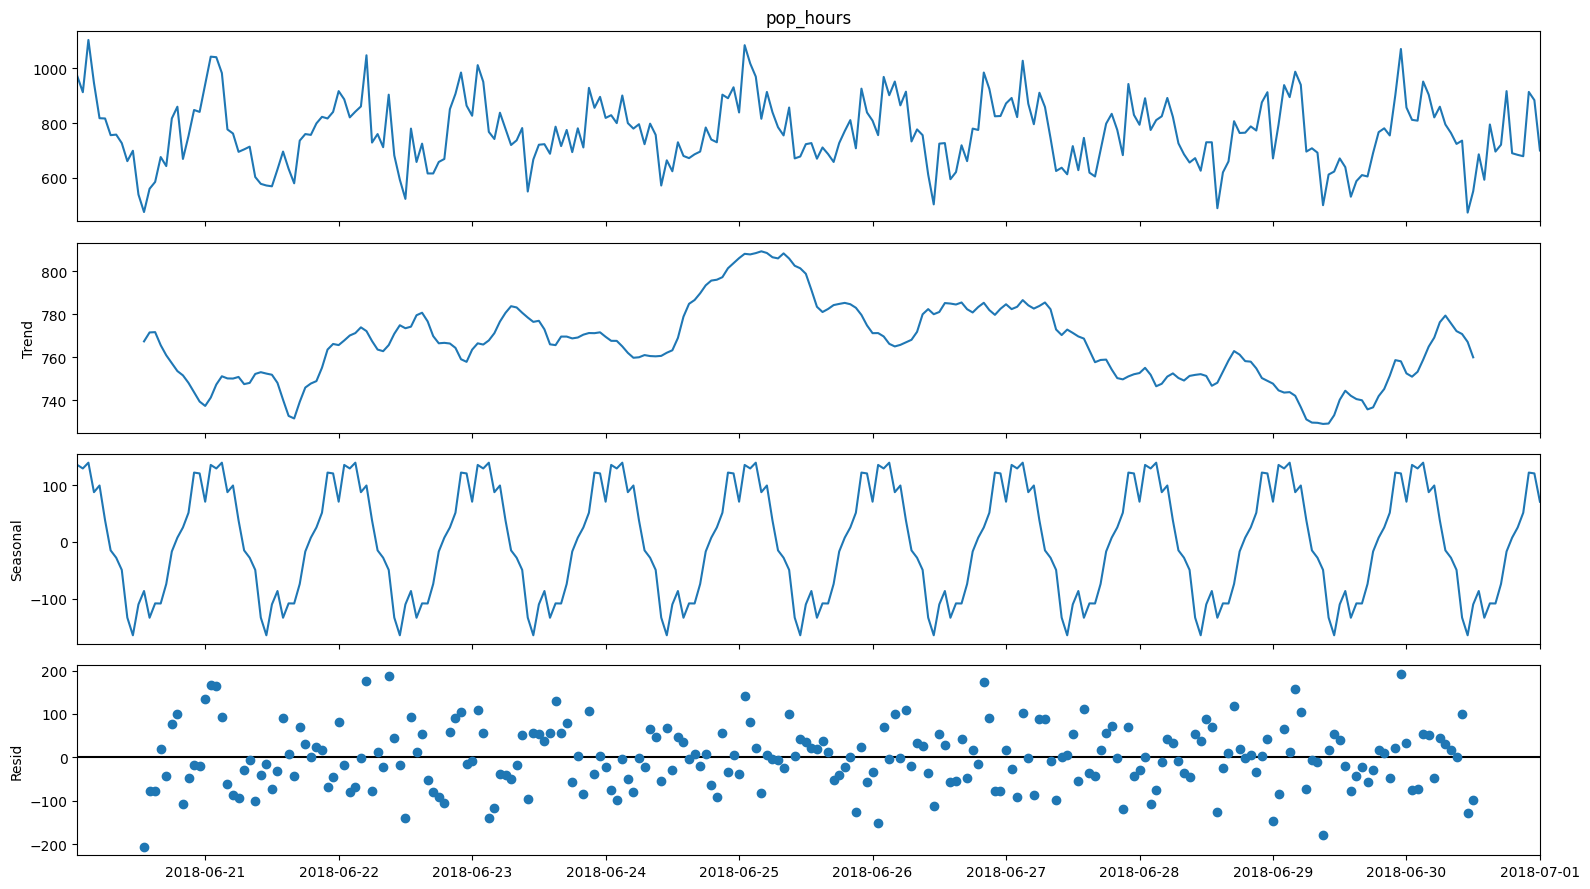

In [25]:
from datetime import timedelta

#4日前から最終日までのデータにフォーカスしてみる． 
ts_check  = ts.iloc[-11*24:]

res_check = sm.tsa.seasonal_decompose(ts_check,period=24)
    
fig    = res_check.plot()
fig.set_size_inches(16,9)
fig.tight_layout()

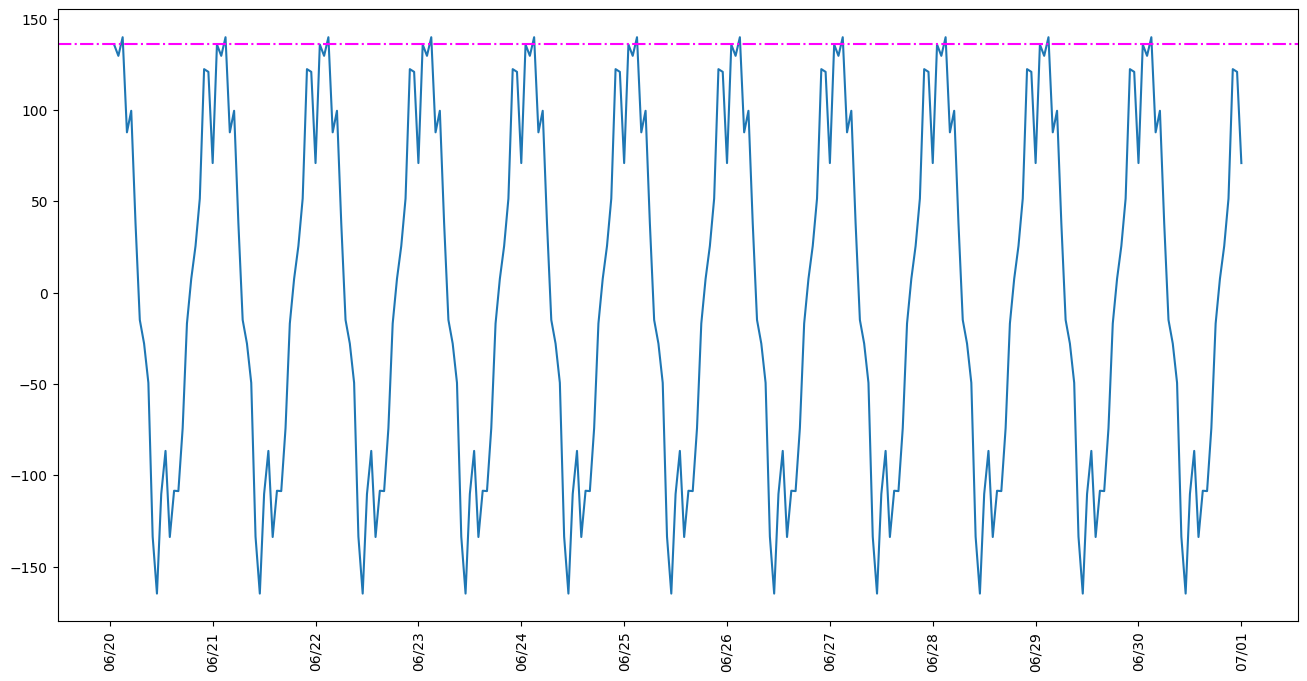

In [26]:
fig, ax = plt.subplots(figsize=(16, 9))

# インデックスを日時にする
res_check.index = pd.to_datetime(ts_check.index)
    #というか，ここで.index を新規作成していて，日時にて.indexを定義している．

# データをプロットする
ax.plot(res_check.index, res_check.seasonal)

# グラフのフォーマットなどの調整
formatter = mdates.DateFormatter("%m/%d")
locator   = mdates.DayLocator()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
fig.autofmt_xdate(rotation=90, ha="center")

val = res_check.seasonal[0]
    #val is the first date of seasonal ingredient
plt.axhline(val, ls = "-.", color = "magenta")

plt.show()

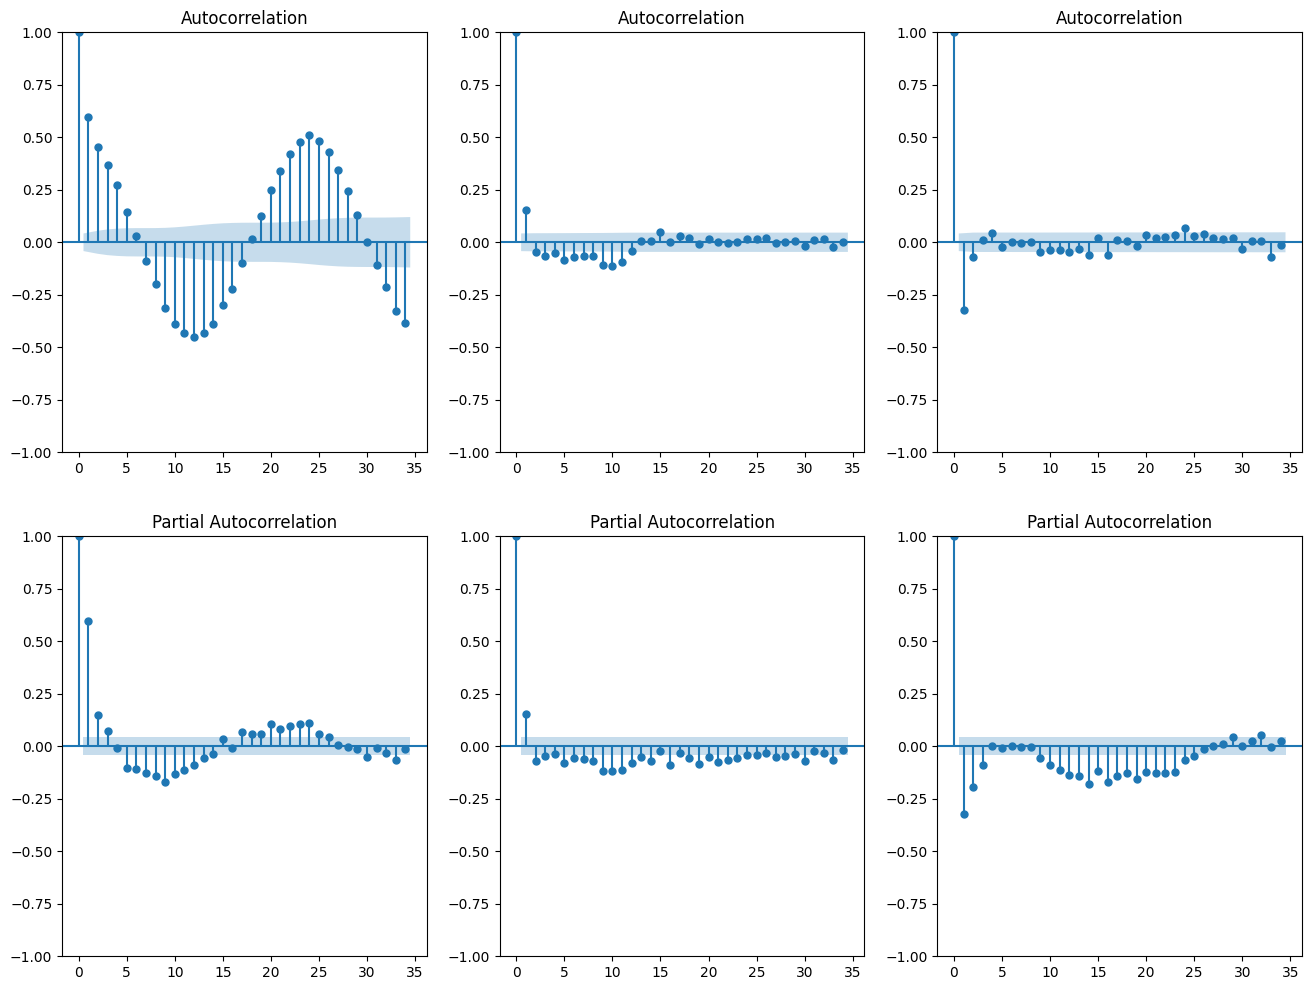

In [27]:
#コレログラム
_, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 12))

# 原系列の ACF 自己相関関数 (ACF)
sm.tsa.graphics.plot_acf(ts, ax=axes[0][0])
# 原系列の PACF
sm.tsa.graphics.plot_pacf(ts, ax=axes[1][0])

# 残差の ACF
sm.tsa.graphics.plot_acf(res.resid.dropna(), ax=axes[0][1])
# 残差の PACF
sm.tsa.graphics.plot_pacf(res.resid.dropna(), ax=axes[1][1])

# 1次の階差系列の ACF
sm.tsa.graphics.plot_acf(ts.diff(1).dropna(), ax=axes[0][2])
# 1次の階差系列の PACF
sm.tsa.graphics.plot_pacf(ts.diff(1).dropna(), ax=axes[1][2])


# グラフを表示する
plt.show()

## ADF検定を行う．
単位根過程(定常性の有無)であるかどうかを確かめる．

In [28]:
print("-------------原系列--------------")
# トレンド項なし、定数項なし
nc = sm.tsa.stattools.adfuller(ts, regression="n")
# トレンド項なし、定数項あり
c = sm.tsa.stattools.adfuller(ts, regression="c")
# トレンド項あり（1次まで）、定数項あり
ct = sm.tsa.stattools.adfuller(ts, regression="ct")
# トレンド項あり（1次+非線形トレンド）、定数項あり
ctt = sm.tsa.stattools.adfuller(ts, regression="ctt")

print("nc  p-value:" + str(nc[1]))
print("c   p-value:" + str(c[1]))
print("ct  p-value:" + str(ct[1]))
print("ctt p-value:" + str(ctt[1]))


print()
print("-------------1次階差系列--------------")
ts_diff = ts.diff().dropna()

# トレンド項なし、定数項なし
nc = sm.tsa.stattools.adfuller(ts_diff, regression="n")
# トレンド項なし、定数項あり
c = sm.tsa.stattools.adfuller(ts_diff, regression="c")
# トレンド項あり（1次まで）、定数項あり
ct = sm.tsa.stattools.adfuller(ts_diff, regression="ct")
# トレンド項あり（1次+非線形トレンド）、定数項あり
ctt = sm.tsa.stattools.adfuller(ts_diff, regression="ctt")

print("nc  p-value:" + str(nc[1]))
print("c   p-value:" + str(c[1]))
print("ct  p-value:" + str(ct[1]))
print("ctt p-value:" + str(ctt[1]))

-------------原系列--------------
nc  p-value:0.5557125603207459
c   p-value:1.5645327563424114e-06
ct  p-value:7.071925095832785e-06
ctt p-value:2.9350216908495672e-06

-------------1次階差系列--------------
nc  p-value:0.0
c   p-value:0.0
ct  p-value:0.0
ctt p-value:0.0


a. 差分の設定（d）

原系列の nc の p-value が 0.4878 と高く、定常ではないため、差分をとる必要がある．
1次差分（d=1） を使用する．

<Axes: xlabel='timeLine'>

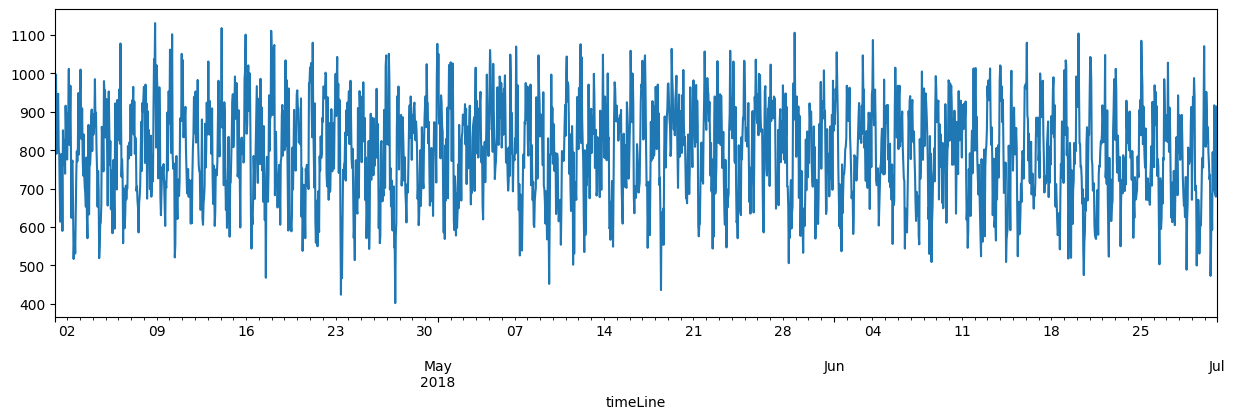

In [29]:
ts.plot()

<Axes: xlabel='timeLine'>

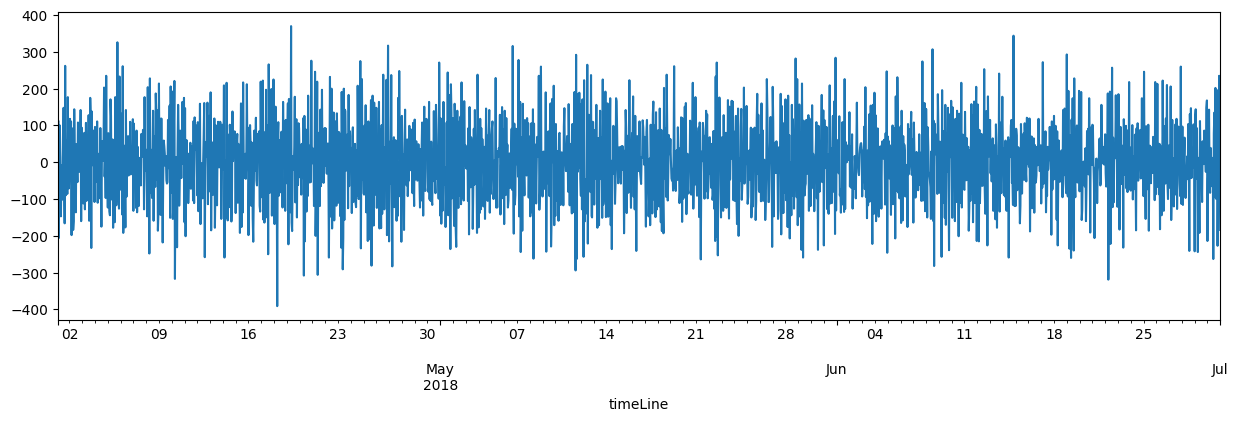

In [30]:
ts_diff.plot()

In [31]:
# params2 = sm.tsa.arma_order_select_ic(ts.dropna(), ic='bic')
# params2

上のbig_min_orderの値でARIMAパラメータ(p,q)を決める．
sarima検定をする場合はそうする．しかし僕の場合はsarimaxを使いたいので，xの情報も含めたモデルを検証すべきだろう．

なので，上のパラメータは使わない．

# パラメータチューニング

## ARIMAモデル(p,d,q)パラメータのチューニング
dはts,ts_diffの目視確認により1と確認するためp,qを求める
[参考サイト](https://qiita.com/KENTAROSZK/items/a8d25122a9659967d9f4)
[参考サイト2](https://brskun.hatenablog.com/entry/2020/08/10/190305)


In [32]:
# Arima_tuning_on = True
Arima_tuning_on = False

In [33]:
if Arima_tuning_on:
    # グリッドサーチで最適な次数を探す、基準はAIC
    # パラメータの範囲を指定
    p = range(0, 4)  # AR次数の範囲
    d = range(0, 1)  # 階差の次数の範囲
    q = range(0, 20)  # MA次数の範囲
    # パラメータの組み合わせを作成
    parameters = [(i, j, k) for i in p for j in d for k in q]
    print(f'number of parameter combination: {len(parameters)}')

    # 最良のモデルを保持するための変数を初期化
    best_aic = np.inf
    best_param_arima = None

    # 各パラメータの組み合わせごとにモデルを評価し、最良のモデルを選択
    for order in parameters:
        try:
            if exDataIsAll:
                exo_data=exo_train
            else:
                exo_data=None
            model = sm.tsa.SARIMAX(ts, order=order, exog = exo_data)
            
            arima_results = model.fit(disp=False)
            if arima_results.aic < best_aic:
                best_aic = arima_results.aic
                best_param_arima = order
            print(order,arima_results.aic)
        except:
            continue
    print('*BEST ARIMA{} - BIC:{}'.format(best_param_arima, best_aic))
else:
    
    # *BEST ARIMA(2, 0, 6) - BIC:20.0
    print('*BEST ARIMA{}'.format(best_param_arima))

*BEST ARIMA[2, 1, 6]


## SARIMAモデル(P,D,Q,s)パラメータのチューニング
sは24と固定

In [34]:
# season_tuning_on = True
season_tuning_on = False

In [35]:
import itertools

# SARIMAのseasonal成分のパラメータを推定するために、各パラメータのパターンを作る
p = range(0, 4)
d = range(0, 3)
q = range(0, 4)
pdq = list(itertools.product(p, d, q))
    #pdq is list, which size is 64
# '24'は周期性が明らかに24だから決め打ちで設定している。
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]


if season_tuning_on:
  best_bic = None

  

  for param_seasonal in seasonal_pdq:
    try:
      if exDataIsAll:
          exo_data=exo_train
      else:
          exo_data=None
      mod = sm.tsa.statespace.SARIMAX(endog = ts,
                                      exog  = exo_data,
                                      order = best_param_arima,
                                      seasonal_order = param_seasonal,
                                      enforce_stationarity = False,
                                      enforce_invertibility = False)
      results = mod.fit(disp=False)
      print('ARIMA{}x{} - BIC:{}'.format(best_param_arima, param_seasonal, results.bic))
      
      if best_bic > results.bic:
          best_param_seasonal = param_seasonal
            #seasonal成分の[P,D,Q]の最適値を更新
          best_bic = results.bic
    
    except:
      continue
  print('*BEST ARIMA{}x{} - BIC:{}'.format(best_param_arima, best_param_seasonal, best_bic))

else:
  
  print('*BEST ARIMA{}x{}'.format(best_param_arima, best_param_seasonal))
  

*BEST ARIMA[2, 1, 6]x[1, 1, 3, 24]


# FORECAST

## 全ての期間で学習させてモデルを作り，次の1時間を予測するSARIMAX

SARIMAXモデルをts全期間分のデーからで作る

In [36]:
# if exDataIsAll:
#     exo_data=exo_train
# else:
#     exo_data=None


# ## モデル作成
# sarimax_model = sm.tsa.SARIMAX(endog = ts,
#                               exog  = exo_data,
#                               order=best_param_arima,
#                               seasonal_order=best_param_seasonal).fit()


# ##予測
# if exDataIsAll:
#     exo_data=exo_test
# else:
#     exo_data=None


# min_date = x_test.index.min()
# max_date = x_test.index.max()
# predict = sarimax_model.get_prediction(start = min_date,
#                                       end   = max_date,
#                                       exog = exo_data)
# predict_value = predict.predicted_mean
# display(predict_value)

グラフ作成

In [37]:
# # 訓練データ・検証データ全体のグラフ化
# fig, ax = plt.subplots(figsize=(16,9))

# # データのプロット
# plt.plot(x_train.index, x_train['pop_hours'],label='TrainData')  # 実データをプロット
#     #x_train is DataFrame

# plt.plot(x_test.index, x_test['pop_hours'],label='Observed')  # 実データをプロット
#     #x_test is DataFrame
# plt.plot(predict_value,label='Predict by SARIMA')  # 予測データをプロット
#     #predict_value is Series with Index of 'Date'
# plt.legend()

# # 日付表記を90度回転
# ax.tick_params(axis='x', rotation=90)
# locator = mdates.DayLocator(interval=1)
# ax.xaxis.set_major_locator(locator)

# # titleなど
# ax.set_xlabel('date')
# ax.set_ylabel('population')

# if exDataIsAll:
#     add_title_name  = ' with Exogenous variables (SARIMAX)'
# else:
#     add_title_name  = ' without exogenous variables (SARIMA)'


# ax.set_title('Predicted population'+add_title_name)

# plt.show()

拡大

In [38]:
# import datetime

# date_for_graph_min='2018-06-25'
# date_for_graph_max='2018-07-12'

# xmin = datetime.datetime.strptime(date_for_graph_min, '%Y-%m-%d')
# xmax = datetime.datetime.strptime(date_for_graph_max, '%Y-%m-%d')

In [39]:
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# # 訓練データ・検証データ全体のグラフ化
# fig, ax = plt.subplots(figsize=(16, 9))


# # データのプロット
# plt.plot(x_train.index, x_train['pop_hours'], label='TrainData')  # 実データをプロット
# plt.plot(x_test.index, x_test['pop_hours'], label='Observed')  # 実データをプロット
# plt.plot(predict_value, label='Predicted by SARIMA')  # 予測データをプロット

# plt.legend()

# # 日付表記を90度回転
# ax.tick_params(axis='x', rotation=90)

# # 横軸の日付フォーマットを "2018-Jun-10" の形式にする
# date_format = mdates.DateFormatter('%Y-%b-%d')
# ax.xaxis.set_major_formatter(date_format)

# # 1日ごとの目盛りを設定
# locator = mdates.DayLocator(interval=1)
# ax.xaxis.set_major_locator(locator)

# # 詳細グリッドを背景に表示
# ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

# # タイトルなど
# plt.xlim([xmin, xmax])
# ax.set_xlabel('date')
# ax.set_ylabel('population')

# if exDataIsAll:
#     add_title_name  = ' with Exogenous variables (SARIMAX)'
# else:
#     add_title_name  = ' without exogenous variables (SARIMA)'
# ax.set_title('Predicted population'+add_title_name)

# plt.show()

今回は予測精度の評価指標としてMAPEを使う。（時系列データの評価指標としてよく使われている）

今回はパーセント表記で返す

In [40]:
# def Mape(predict, observed):
#   absolute_diff_percentage =  abs( (predict - observed) / observed)*100 
#   sum_abs_diff = sum(absolute_diff_percentage)
#   mape = sum_abs_diff / len(predict)
#   #mape は GroudTruth を基準にしたときの予測値のずれの比率について，全データを計算したときの，データ1つあたりの平均
  
#   return mape

In [41]:
# # MAPEの計算
# mape = Mape(predict_value, x_test["pop_hours"].values)

# # 結果を出力
# print("mape : " + str(mape * 100) + " %")
# print('This means that each difference ratio on each day is', str(mape * 100), '%.')

### Pickles

In [42]:
# import pickle
# import datetime

# dt_now = datetime.datetime.now()
# dt_str = dt_now.strftime('%Y%m%d_%H%M')

# ### 保存したい複数の変数
# a = sarimax_model
# b = x_train
# c = x_test
# d = exo_train
# e = exo_test

# ### pickleで保存（書き出し）: 辞書にして複数の変数を保存
# with open(f'./pickles/sarimax_model_{dt_str}.pickle', mode='wb') as fo:
#     pickle.dump({'model': a, 'train_data': b, 'test_data': c, 'exo_train': d, 'exo_test': e}, fo)

# ### pickleで保存したファイルを読み込み
# with open(f'./pickles/sarimax_model_{dt_str}.pickle', mode='rb') as fi:
#     data = pickle.load(fi)

# # 保存した変数を個別に取得
# a_loaded = data['model']
# b_loaded = data['train_data']
# c_loaded = data['test_data']
# d_loaded = data['exo_train']
# e_loaded = data['exo_test']

# # print(a_loaded)
# # print(b_loaded)
# # print(c_loaded)
# # print(d_loaded)
# # print(e_loaded)

## 毎回学習させてモデルを作り，次の1時間を予測するSARIMAX

In [ ]:
import os
import pickle
import datetime
import pandas as pd
import statsmodels.api as sm
from datetime import timedelta

predict_timeline_list = []
predict_value_list = []

# 初期日時
current_date = split_date
estimation_first_day = current_date

# データ前処理
current_date = datetime.datetime.strptime(current_date, '%Y-%m-%d %H:%M:%S')
print(f'プログラム開始時刻:{datetime.datetime.now()}')

# {forecasting_hours}回の予測を繰り返す
for _ in range(forecasting_hours):
    tmp_now=datetime.datetime.now()
    # 52時間分のデータを取得
    end_train_date = current_date - timedelta(hours=1)
    start_train_date = end_train_date - timedelta(days=train_days)  # train_days日間で学習
    print(f'Train period: {start_train_date} -> {end_train_date} , Forecast: {current_date}',end='\t')
    # インデックスがdatetime型であることを確認
    all_concated.index = pd.to_datetime(all_concated.index)

    pd_exog_data_train = all_concated.drop(columns='pop_hours')[start_train_date:end_train_date]

    # SARIMAモデルの構築
    if exDataIsAll:
        exo_data = pd_exog_data_train
    else:
        exo_data = None

    sarimax_model = sm.tsa.SARIMAX(endog=all_concated[start_train_date:end_train_date]['pop_hours'],
                                    exog=exo_data, 
                                    order=best_param_arima,
                                    seasonal_order=best_param_seasonal).fit(disp=False)

    # 1時間後の予測を行う
    start_test_date = current_date
    end_test_date = current_date + timedelta(hours=1)

    pd_exog_data_test = all_concated.drop(columns='pop_hours')[start_test_date:end_test_date]

    if exDataIsAll:
        exo_data = pd_exog_data_test
    else:
        exo_data = None

    predict = sarimax_model.get_prediction(start=start_test_date, end=end_test_date, exog=exo_data)
    predict_value = predict.predicted_mean.loc[end_test_date]
    
    # output用
    predict_timeline_list.append(end_train_date)
    predict_value_list.append(predict_value)

    # 1時間後のGround Truthを取得
    observed_val = all_concated.loc[end_test_date, 'pop_hours']

    diff_time=datetime.datetime.now()-tmp_now
    print(f"{(diff_time.seconds/60):03.0f}分, 実測値: {observed_val}\t予測値: {predict_value:.0f}\t誤差: {observed_val-predict_value:.0f}")


    # 日時を更新
    current_date += timedelta(hours=1)

print('for終了')


プログラム開始時刻:2024-10-15 16:34:13.979868
Train period: 2018-01-01 23:00:00 -> 2018-06-30 23:00:00 , Forecast: 2018-07-01 00:00:00	

# Pickle

In [ ]:
import pickle

# 実行ごとにディレクトリを作成
dt_now = datetime.datetime.now()
dir_str = dt_now.strftime('%Y%m%d-%H%M%S')   #20240914-193000
directory = f'./pickles/{dir_str}/'

# ディレクトリが存在しない場合は作成
os.makedirs(directory, exist_ok=True)
# pickle #####################
# 保存する時間情報

### 保存したい複数の変数
a = sarimax_model
b = start_test_date
c = end_test_date
d = pd_exog_data_test
e = exo_data
f = predict_value
g = predict_timeline_list
h = predict_value_list
i = all_concated
j = best_param_arima  
k = best_param_seasonal  

### pickleで保存（書き出し）: 辞書にして複数の変数を保存
pickle_path = os.path.join(directory, f'vars.pickle')
with open(pickle_path, mode='wb') as fo:
    pickle.dump({
        # 'sarimax_model': a, 
        'start_test_date': b, 
        'end_test_date': c, 
        # 'pd_exog_data_test': d, 
        # 'exo_data': e, 
        # 'predict_value': f, 
        'predict_timeline_list': g, 
        'predict_value_list': h,
        'all_concated': i,
        'best_param_arima': j,  
        'best_param_seasonal': k  
    }, fo)


In [501]:
import os

md_file_path = os.path.join(directory, f'report.md')
with open(md_file_path, 'w') as md_file:
    md_file.write(f"""
# Report for This SARIMAX model

File created time: {dir_str}

## MeshID
{PATH_mesh}

## Imput vars

### Exo data:
- {exDataIsAll}

### Exogenous data:
 
### Period:
- test_start_date     = {test_start_date}
- test_end_date       = {test_end_date}
- trian_days          = {train_days}
- 

### Parameter
- Best ARIMA Parameters: {best_param_arima}
- Best Seasonal Parameters: {best_param_seasonal}


""")

In [496]:
predict_value_Series=pd.Series(predict_value_list,name='predict_value')
predict_timeline_Series=pd.Series(predict_timeline_list,name='timeLine')

In [ ]:
estimated_Series=pd.concat([predict_timeline_Series,
                            predict_value_Series],axis=1)
estimated_Series = estimated_Series.set_index('timeLine')
estimated_Series

### グラフを絵画

In [ ]:
# 訓練データ・検証データ全体のグラフ化
fig, ax = plt.subplots(figsize=(16,9))


plt.plot(estimated_Series,label='Predict by SARIMAX')  # 予測データをプロット

plt.plot(x_train['pop_hours'],label='TrainData')  # 実データをプロット
plt.plot(x_test['pop_hours'],label='Observed')  # 実データをプロット

plt.legend()

# 日付表記を90度回転
ax.tick_params(axis='x', rotation=90)
locator = mdates.DayLocator(interval=1)
ax.xaxis.set_major_locator(locator)

# titleなど
ax.set_xlabel('Date')
ax.set_ylabel('Population')
if exDataIsAll:
    add_title_name  = ' with Exogenous variables (SARIMAX)'
else:
    add_title_name  = ' without exogenous variables (SARIMA)'
ax.set_title('Predicted population'+add_title_name)

### mapeの計算

In [499]:
def Mape(predict, observed):
  absolute_diff_percentage =  abs( (predict - observed) / observed)
  # print(f'Each diff ratio on each hour: {absolute_diff_percentage}')
  sum_abs_diff = sum(absolute_diff_percentage)
  print()
  # print(f'SUM: {sum_abs_diff}')

  mape = sum_abs_diff / len(predict)
  print(f'MAPE : {mape}')
  #mape は GroudTruth を基準にしたときの予測値のずれの比率について，全データを計算したときの，データ1つあたりの平均

In [ ]:
Mape_val=Mape(estimated_Series['predict_value'],x_test['pop_hours'].values)
# MAPE : 0.2195586694066084

# 以下test